In this notebook, I present a case study for modeling wine quality based on a dataset related to the red variant of the Portuguese “Vinho Verde” wine.
The report is organized as follows: the first chapter describes the dataset; in the second chapter, I discuss Exploratory Data Analysis (EDA) including data processing, missing values, correlation plots, outliers and so on; the third chapter presents Deep Learning experiments and conclusions.


In [1]:
#Imports
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.utils.data import TensorDataset
from torch.nn import ReLU
from torch.nn import Softmax
from imblearn.over_sampling import SMOTE 
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
wine_dataset = pd.read_csv("/Users/Casella/Documents/DATA SCIENCE/2 ANNO/NEURAL COMPUTING/PROJECT/Exams_wine_wine.csv")

The Red Wine dataset contains 1599 observations and 12 variables.

Input variables:
1. Fixed acidity, the fixed acids involved with wine that do not evaporate readily
2. Volatile acidity, the amount of acetic acids in wine, which at too high of levels can lead to an unpleasant, vinegar taste
3. Citric acid, which is found in small quantities but can add “freshness” and flavor to wines
4. Residual sugar, the amount of sugar remaining after fermentation stops
5. Chlorides, the amount of salt in the wine
6. Free sulfur dioxide, the free form of SO2 exists in equilibrium
between molecular SO2 (as a dissolved gas) and bisulfite ion, which
prevents microbial growth and the oxidation of wine
7. Total sulfur dioxide, amount of free and bound forms of SO2
8. Density, the density of water is close to that of water depending on
the percent alcohol and sugar content
9. pH, describes how acidic or basic a wine is on a scale from o (very
acidic) to 14 (very basic)
10. Sulphates, a wine additive which can contribute to sulfur dioxide
gas SO2 levels, which acts as an antimicrobial and antioxidant 
11. Alcohol, the percent alcohol content of the wine
<br>Output variable:
12. Quality, the sensory data, median of at least 3 evaluations graded
by wine experts between 0 (very bad) and 10 (excellent). However, in the dataset there are only values ranging from 3 to 8.

In [3]:
wine_dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


We find that the mean of quality score is about 5.64 and we can see using the interquartile range (IQR), calculated as the difference between the 75th and 25th percentiles, that most variables have outliers. Moreover, for example, we can see that there is a large difference between 75th percentile and max values of Residual Sugar, Free Sulfur Dioxide and Total Sulfur Dioxide. Thus observation suggests that there are extreme values or outliers in the dataset. However, I will identify outliers later using visualization techniques.
From this picture we can see also that mean value is higher than the median value of each column.

In [4]:
summary_stats = wine_dataset.describe()
sum_stats = summary_stats.transpose() #for a better visualization
sum_stats = sum_stats.drop(['count'], axis=1) #remove the count column because it is unuseful
sum_stats

,mean,std,min,25%,50%,75%,max
fixed acidity,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


Now let’s check if there is any missing value in the data. Missing values are always a problem while analyzing the data and also building the models using that data. 

In [5]:
# Checking for null values
wine_dataset.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [6]:
wine_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


The below-shown picture will print the number of unique values in each of the features.

In [7]:
for col in wine_dataset.columns.values:
    print("Number of unique values of {}: {}".format(col, wine_dataset[col].nunique()) )

Number of unique values of fixed acidity: 96
Number of unique values of volatile acidity: 143
Number of unique values of citric acid: 80
Number of unique values of residual sugar: 91
Number of unique values of chlorides: 153
Number of unique values of free sulfur dioxide: 60
Number of unique values of total sulfur dioxide: 144
Number of unique values of density: 436
Number of unique values of pH: 89
Number of unique values of sulphates: 96
Number of unique values of alcohol: 65
Number of unique values of quality: 6


We can see that the feature with the maximum unique value is density, and the feature that has the minimum unique value is quality, so let’s see these unique values of quality.

In [8]:
wine_dataset.quality.unique()

array([5, 6, 7, 4, 8, 3])

This tells us vote count of each quality score in descending order. Quality has most values concentrated in the categories 5,6 and 7. Only a few observations made for the categories 3 and 8.

In [9]:
wine_dataset.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

From these insights we can identify class imbalance which can help you understand and fix classification errors at a later stage. Here the classes are ordered and not balanced (there are much more normal wine than excellent or poor ones).


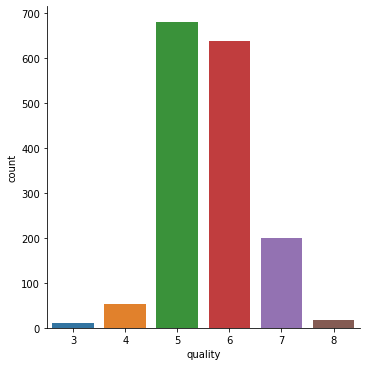

In [10]:
sns.catplot(x='quality', data=wine_dataset, kind='count')

Now, I will show the PDF plots visualizing the spread of the data.

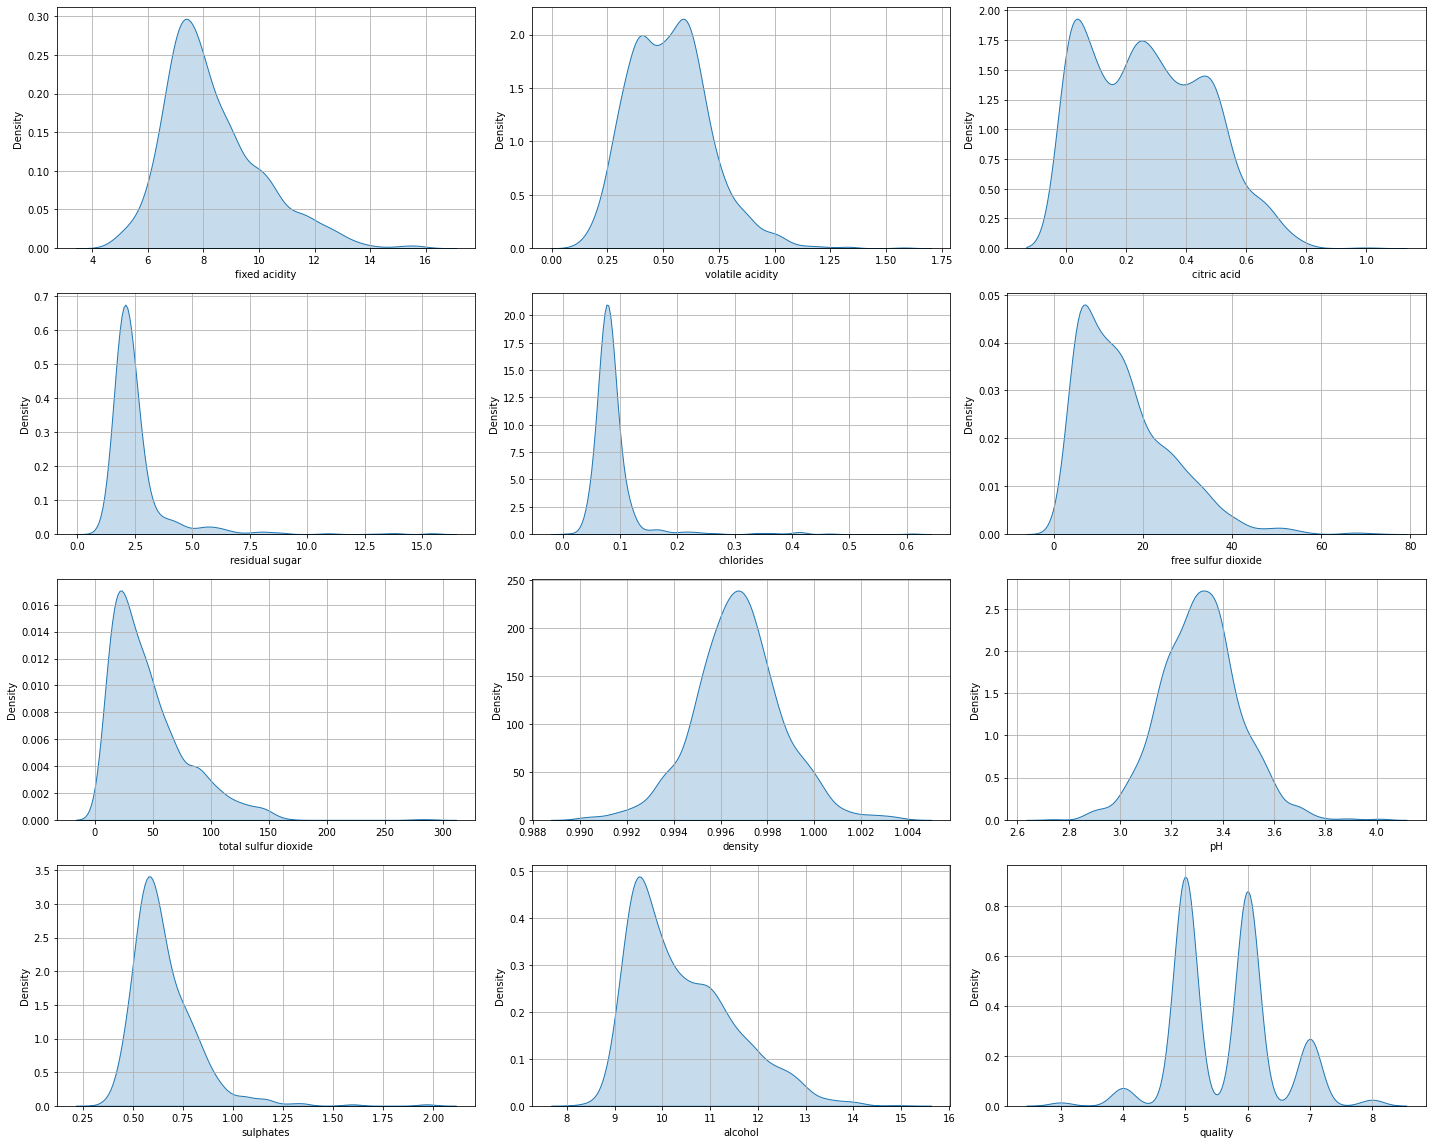

In [11]:
plt.figure(figsize=(20, 16))
for i, col in enumerate(list(wine_dataset.columns.values)):
    plt.subplot(4, 3, i+1)
    sns.kdeplot(wine_dataset[col], fill= True)
    plt.grid()
    plt.tight_layout()

It can be seen that most wines’ pH levels are between 3 and 3.6, and that chlorides is most prevalent at level 0.1. Some distributions are bimodal or trimodal, so they possibly have 2 or 3 classes, like volatile acidity, citric acid and alcohol.
Moreover, we can see that pH and density are approximately normally distributed, and the remaining features are positively skewed. Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. Finally, all the features except citric acid are leptokurtic.


In [12]:
print("Skewness\n", wine_dataset.skew())
print("\nKurtosis\n ", wine_dataset.kurt())

Skewness
 fixed acidity           0.982751
volatile acidity        0.671593
citric acid             0.318337
residual sugar          4.540655
chlorides               5.680347
free sulfur dioxide     1.250567
total sulfur dioxide    1.515531
density                 0.071288
pH                      0.193683
sulphates               2.428672
alcohol                 0.860829
quality                 0.217802
dtype: float64

Kurtosis
  fixed acidity            1.132143
volatile acidity         1.225542
citric acid             -0.788998
residual sugar          28.617595
chlorides               41.715787
free sulfur dioxide      2.023562
total sulfur dioxide     3.809824
density                  0.934079
pH                       0.806943
sulphates               11.720251
alcohol                  0.200029
quality                  0.296708
dtype: float64


To see which variables are likely to affect the quality of wine the most, I ran a correlation analysis.
In order of highest correlation: alcohol, volatile acidity, sulphates, citric acid, total sulfur dioxide, density, chlorides, fixed acidity, pH, free sulfur dioxide, residual sugar.

<AxesSubplot:>

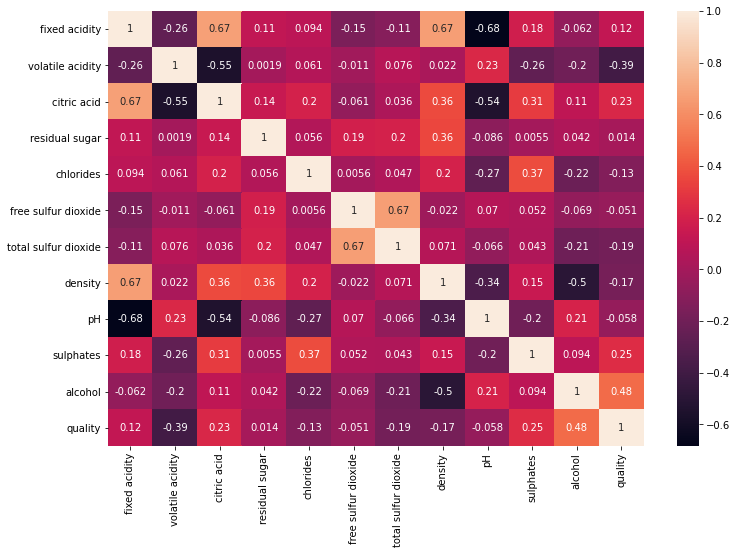

In [13]:
plt.figure(figsize=(12,8))
sns.heatmap(wine_dataset.corr(), color = "k", annot=True)

And now I plot pairwise relationships in the dataset.

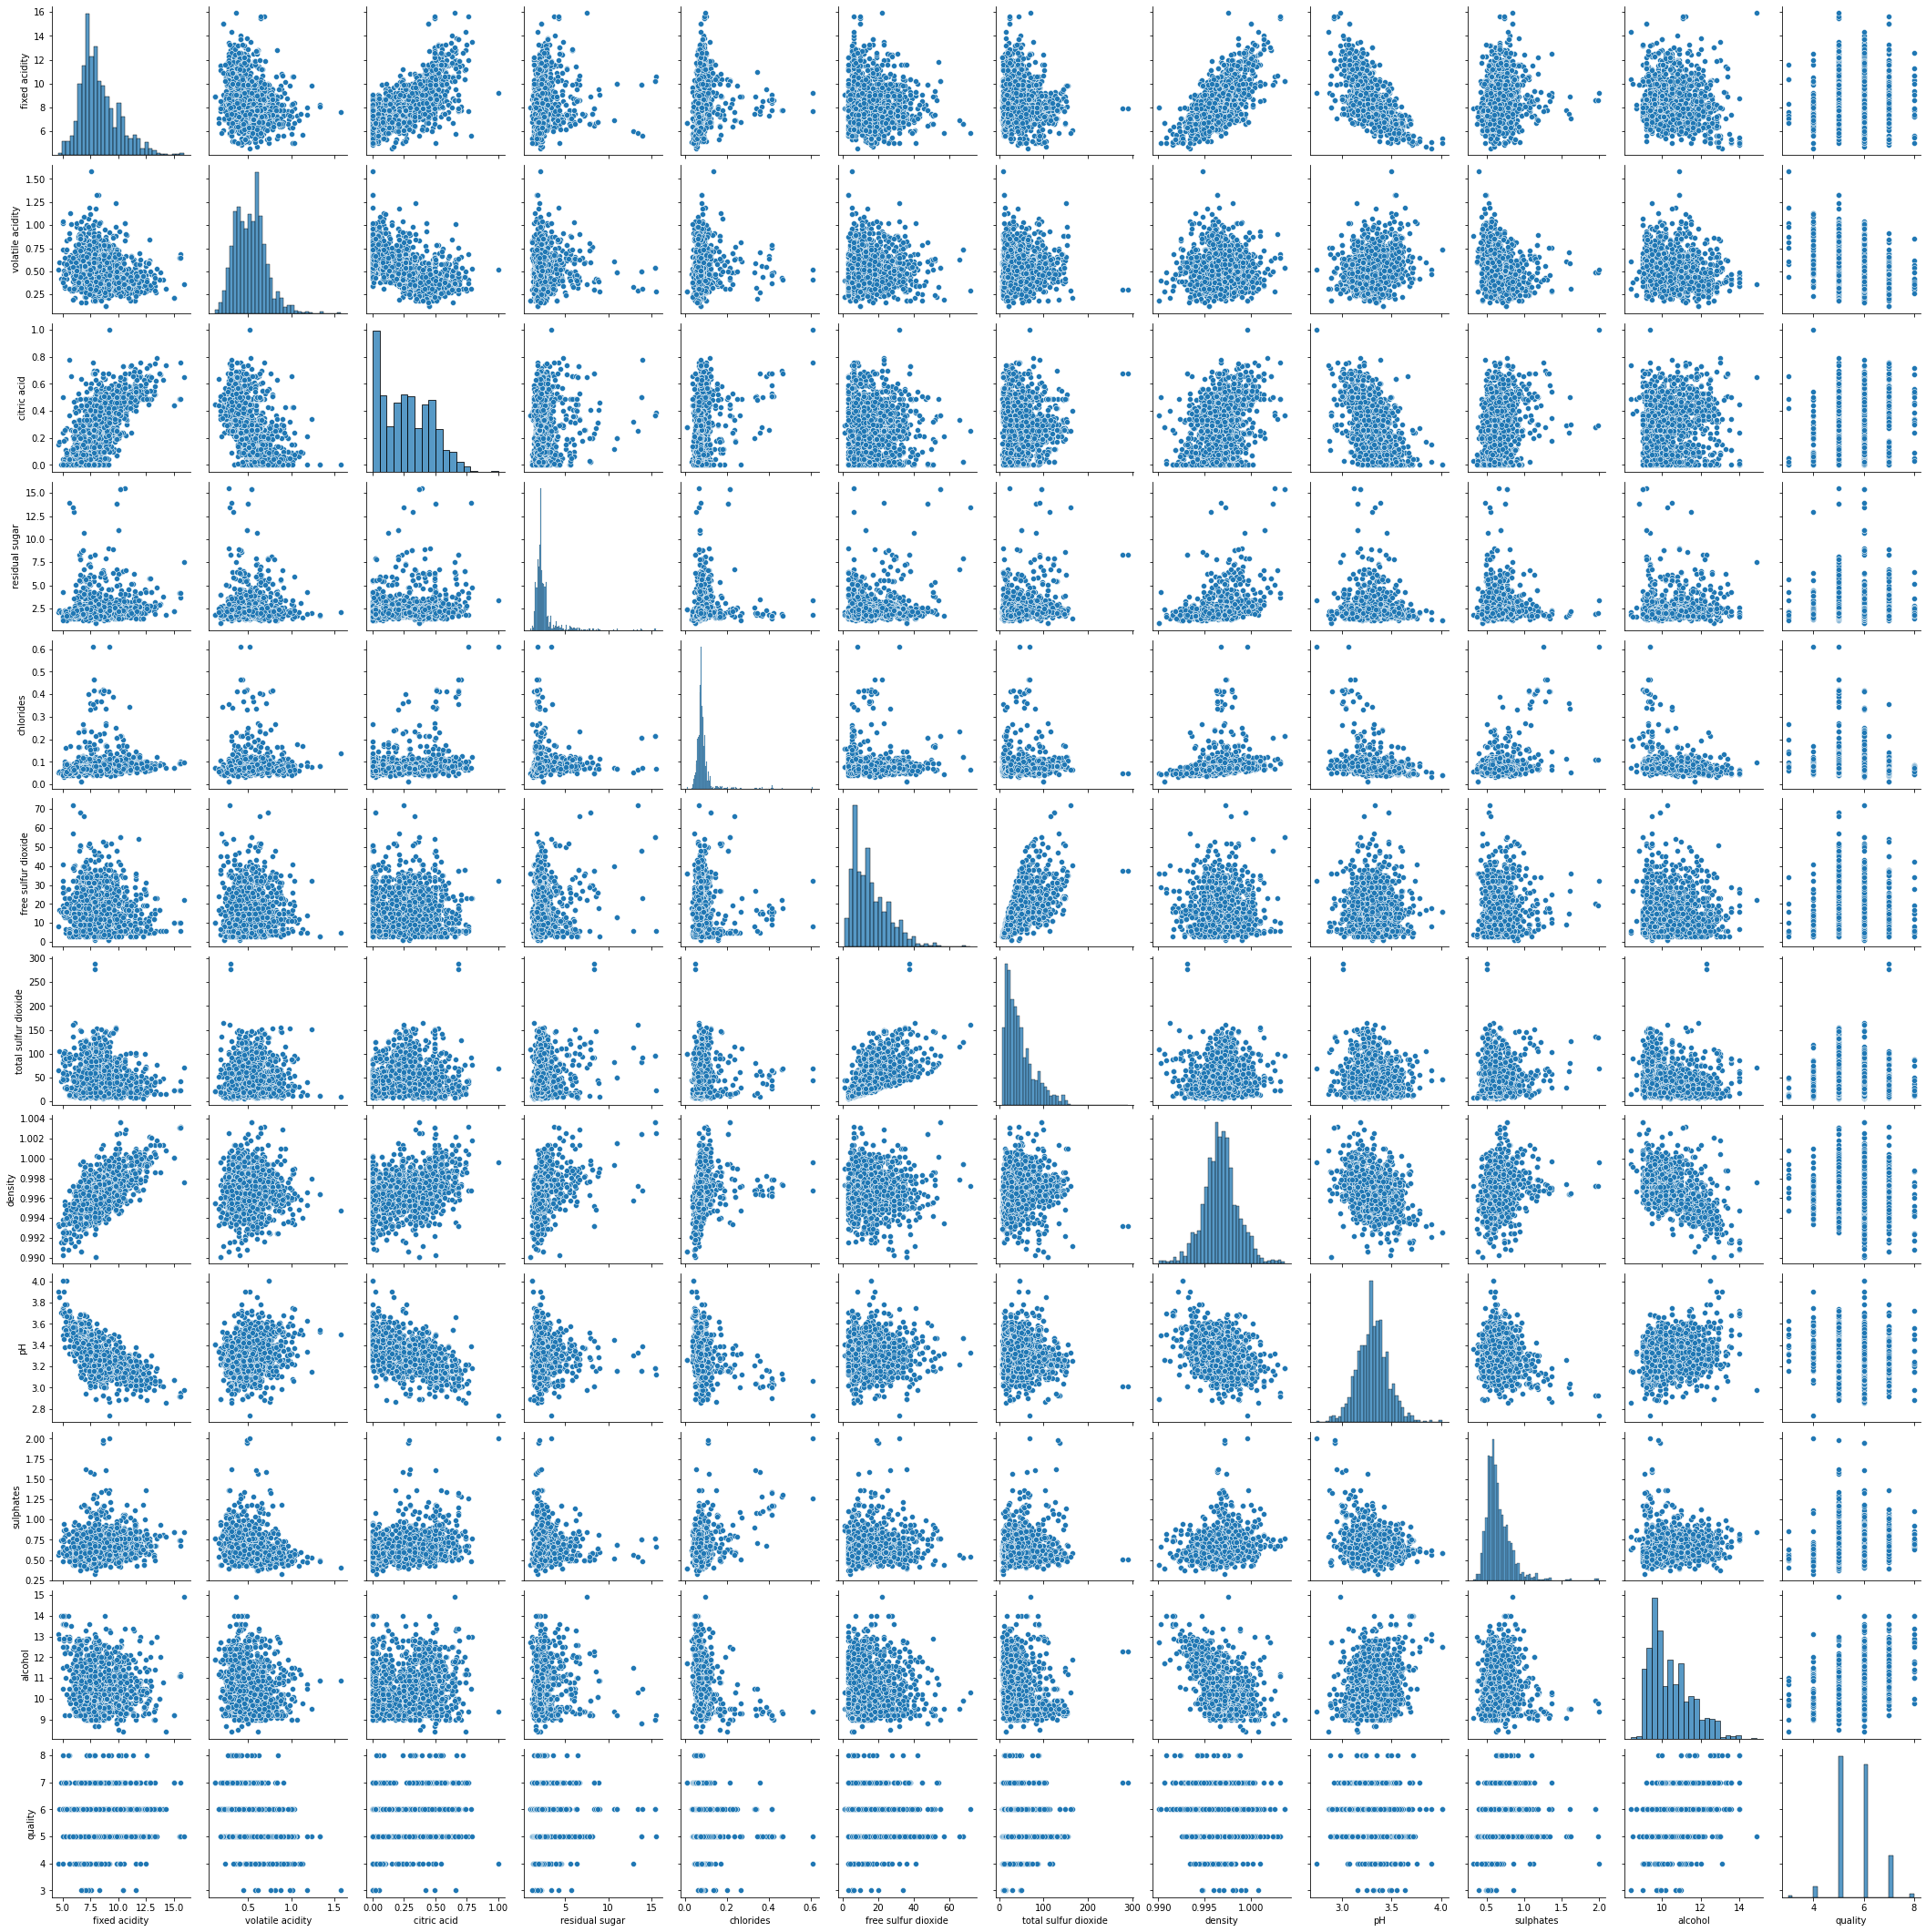

In [14]:
sns.pairplot(data = wine_dataset, kind='scatter')

From the above heatmap and correlation plot on red wine, we have the following inference: 1. It looks like we have pH and fixed acidity with inverse relationship between them, and also for citric acid and volatile acidity. 2. There is a strong positive relationship between total sulfur dioxide and free sulfur dioxide.
Moreover, fixed acidity, citric acidity and density are highly correlated, likewise free sulfur dioxide and total sulfur dioxide. So, I can drop the variables citric acidity, density and free sulfur dioxide to reduce multicollinearity.


In [15]:
wine_dataset = wine_dataset.drop(columns=['citric acid','density','free sulfur dioxide'])
wine_dataset

,fixed acidity,volatile acidity,residual sugar,chlorides,total sulfur dioxide,pH,sulphates,alcohol,quality
0,7.4,0.700,1.9,0.076,34.0,3.51,0.56,9.4,5
1,7.8,0.880,2.6,0.098,67.0,3.20,0.68,9.8,5
2,7.8,0.760,2.3,0.092,54.0,3.26,0.65,9.8,5
3,11.2,0.280,1.9,0.075,60.0,3.16,0.58,9.8,6
4,7.4,0.700,1.9,0.076,34.0,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,2.0,0.090,44.0,3.45,0.58,10.5,5
1595,5.9,0.550,2.2,0.062,51.0,3.52,0.76,11.2,6
1596,6.3,0.510,2.3,0.076,40.0,3.42,0.75,11.0,6
1597,5.9,0.645,2.0,0.075,44.0,3.57,0.71,10.2,5


Going back to the previous argument of outliers: in statistics, an outlier is a data point that differs significantly from other observations. An outlier may be due to variability in the measurement or it may indicate experimental error. And because the quality of the input of our model decides the quality of the output, detecting and treating/removing outliers is an important step in the data exploration stage. I used boxplots that display the five-number summary of a set of data: minimum, 1st quartile, median, 3rd quartile, and maximum. In a boxplot we draw a box from the 1st quartile to the 3rd quartile. A vertical line goes through the box at the median. The whiskers go from each quartile to the minimum or maximum.



In [16]:
outliers = []  # list to store outliers value

# method for detecting the outliers using interquantilerange technique 
def detect_outliers(data): 
    quantile1, quantile3 = np.percentile(data, [25, 75])  # create two quantiles for 25% and 75%
    iqr_val = quantile3 - quantile1                       # interquantilerange value
    lower_bound_value = quantile1 - (1.5 * iqr_val)       # lower limit of the data, anything greater are not outliers
    upper_bound_value = quantile3 + (1.5 * iqr_val)       # upper limit of the data, anything less are not outliers
    
    for i in data:
        if lower_bound_value < i < upper_bound_value:     # if data[value] is greater than lbv and less than ubv than it is not considered as an outlier
            pass
        else:
            outliers.append(i)
            
    return lower_bound_value, upper_bound_value           # return lower bound and upper bound value for the data

In [17]:
# Custom boxplot
def box_plot(data, height = 10, width = 16, title = "Boxplot"):
    # Make the figure object
    plt.figure(figsize=(width, height))
    # Add title
    plt.suptitle(title, y = 0.94, fontsize = 30)
    # Scale the font size
    sns.set(font_scale = 2)
    # Create the boxplot
    sns.boxplot(data = data, orient = "h")

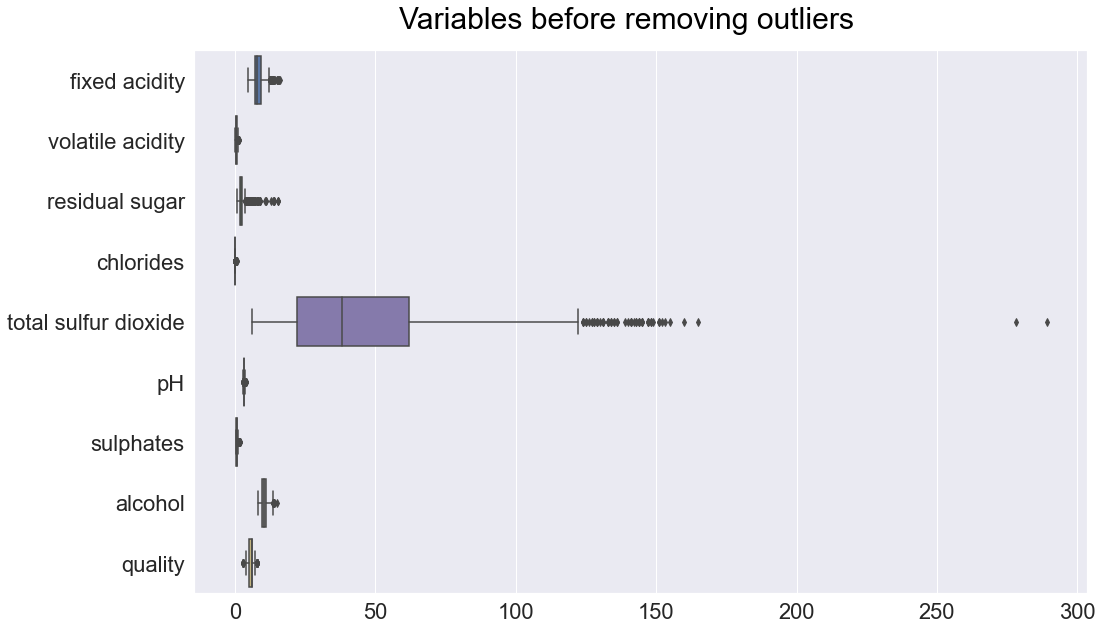

In [18]:
box_plot(wine_dataset, title="Variables before removing outliers")

The picture above is an overview of all the boxplots before removing outliers. Now I show the boxplot for each variable in a different graph, for better visualization.

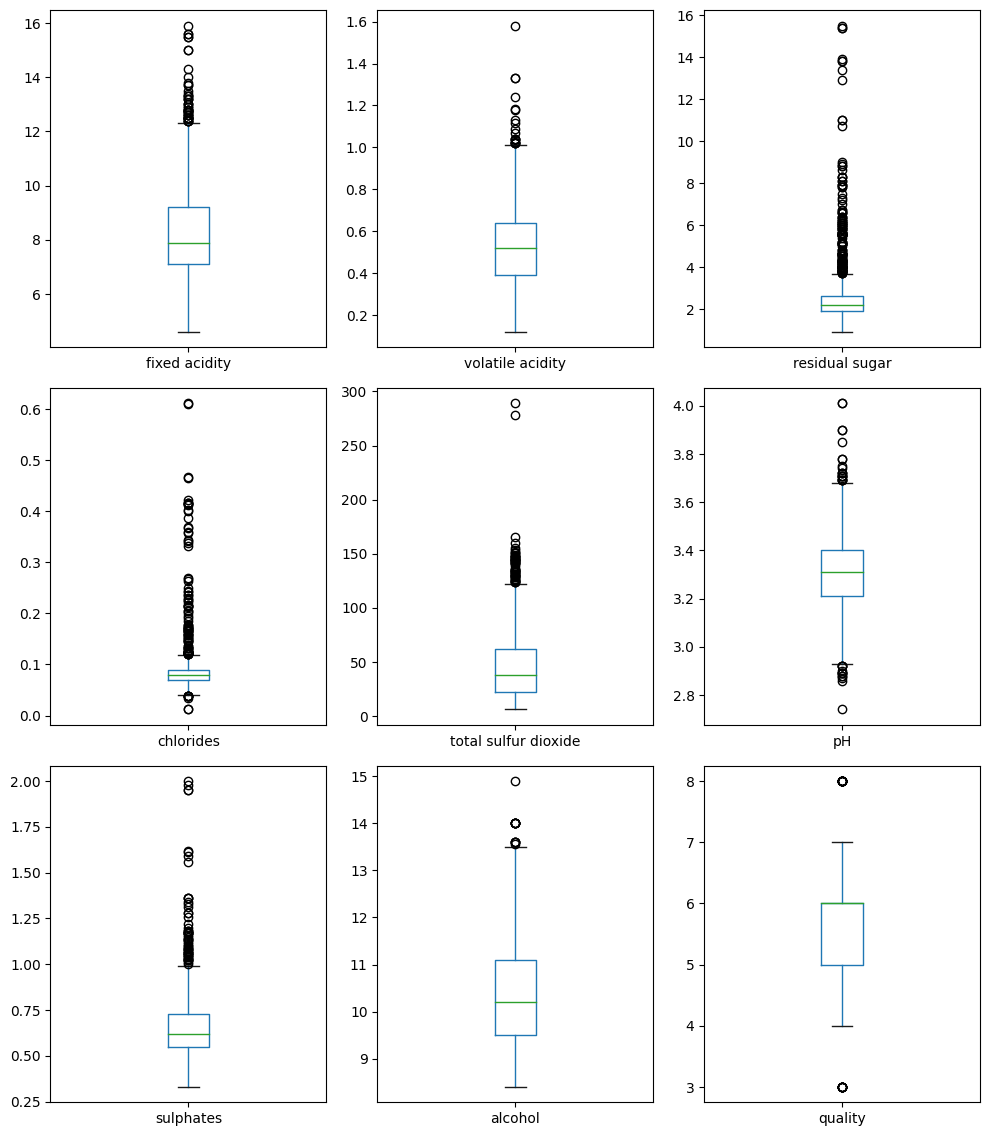

In [19]:
plt.style.use("default")
plt.figure(figsize=(10,15))
for i, col in enumerate(list(wine_dataset.columns.values)):
    plt.subplot(4,3,i+1)
    wine_dataset.boxplot(col)
    plt.grid()
    plt.tight_layout()

All the features have outliers. Most of them present a lot of outliers. Instead, quality has only 2 outliers, alcohol 3 and citric acid 1. Other methods to detect outliers could be using statistical tests like Peirce’s Criterion, Chauvenet’s Criterion, Grubb’s test or Dixon’s test.
Now, there are different ways to proceed in case you have outliers. If it is obvious that the outlier is due to incorrectly enter or measured data, or if you have a lot of data so your sample won’t be hurt by dropping a questionable outlier, or if you can go back and recollect the questionable data point, you should drop the outlier. 
Instead, if your results are critical, so even small changes will matter a lot, or if there are a lot of outliers, you should not drop the outlier.
In practice, I will remove most of the outliers using the following method: I calculate the Inter Quartile Range that is IQR=Q3-Q1 and then, any value below Q1-1.5*IQR and Q3+1.5*IQR is an outlier.
It can be seen from the picture below that we have successfully removed most of the outliers for all variables.


In [20]:
detect_outliers(wine_dataset["fixed acidity"])

(3.95, 12.349999999999998)

In [21]:
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["fixed acidity"]>12.349999999999998].index)

In [22]:
detect_outliers(wine_dataset["volatile acidity"])

(0.027500000000000024, 1.0075)

In [23]:
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["volatile acidity"]>1.0075].index)

In [24]:
detect_outliers(wine_dataset["residual sugar"])

(0.8499999999999996, 3.6500000000000004)

In [25]:
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["residual sugar"]>3.6500000000000004].index)

In [26]:
detect_outliers(wine_dataset["chlorides"])

(0.0415, 0.11750000000000002)

In [27]:
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["chlorides"]>0.11750000000000002].index)

In [28]:
detect_outliers(wine_dataset["total sulfur dioxide"])

(-32.5, 115.5)

In [29]:
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["total sulfur dioxide"]>115.5].index)

In [30]:
detect_outliers(wine_dataset["pH"])

(2.96, 3.6800000000000006)

In [31]:
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["pH"]>3.68].index)
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["pH"]<2.96].index)

In [32]:
detect_outliers(wine_dataset["sulphates"])

(0.31000000000000016, 0.9499999999999998)

In [33]:
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["sulphates"]>0.9499999999999998].index)

In [34]:
detect_outliers(wine_dataset["alcohol"])

(7.124999999999975, 13.458333333333375)

In [35]:
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["alcohol"]>13.458333333333375].index)

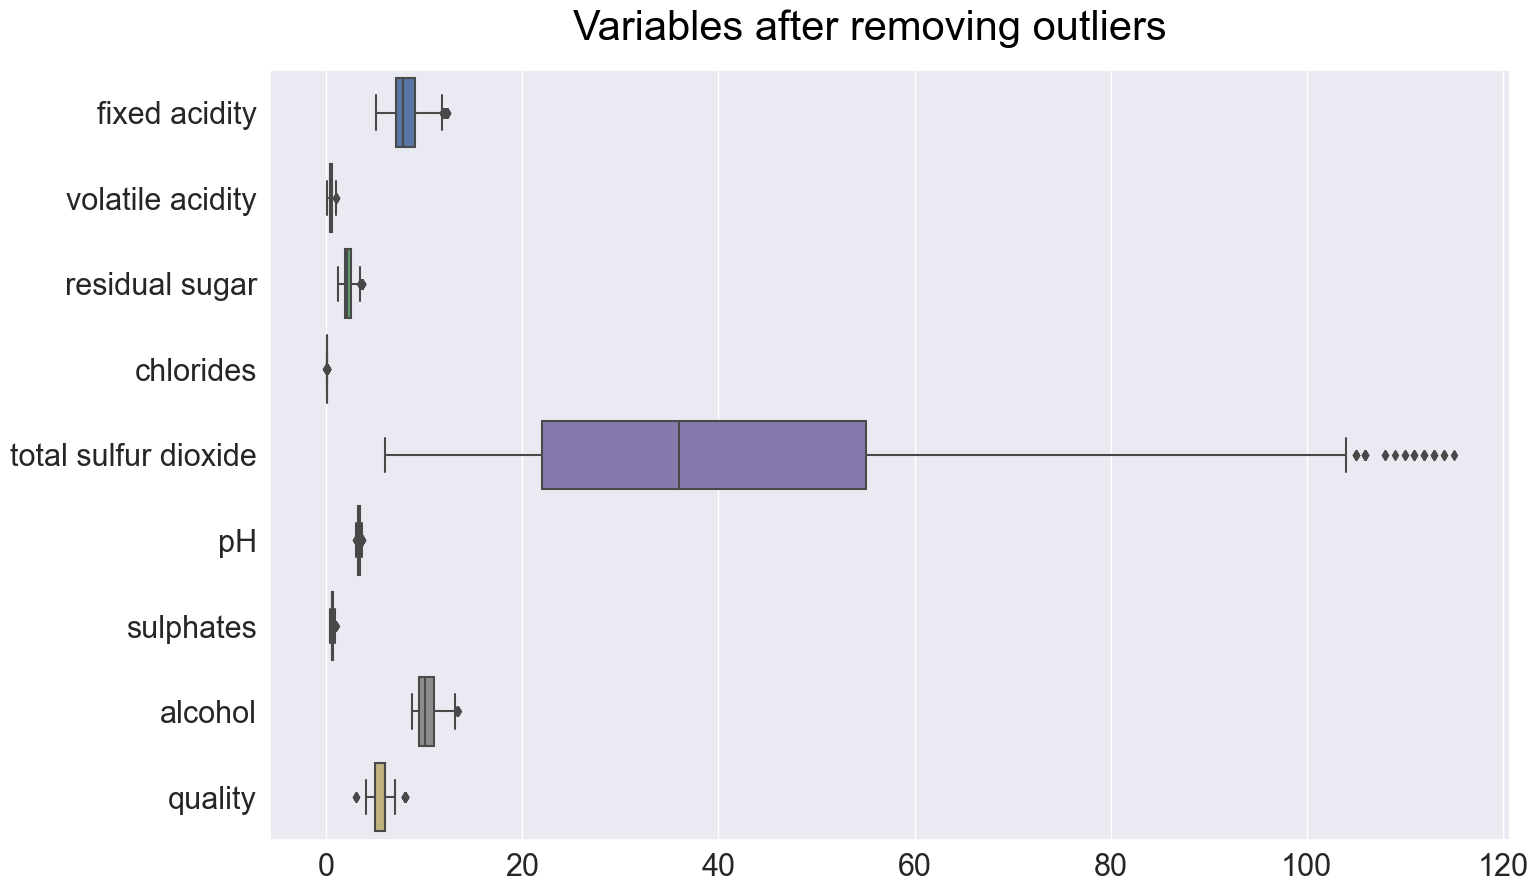

In [36]:
box_plot(wine_dataset, title="Variables after removing outliers")

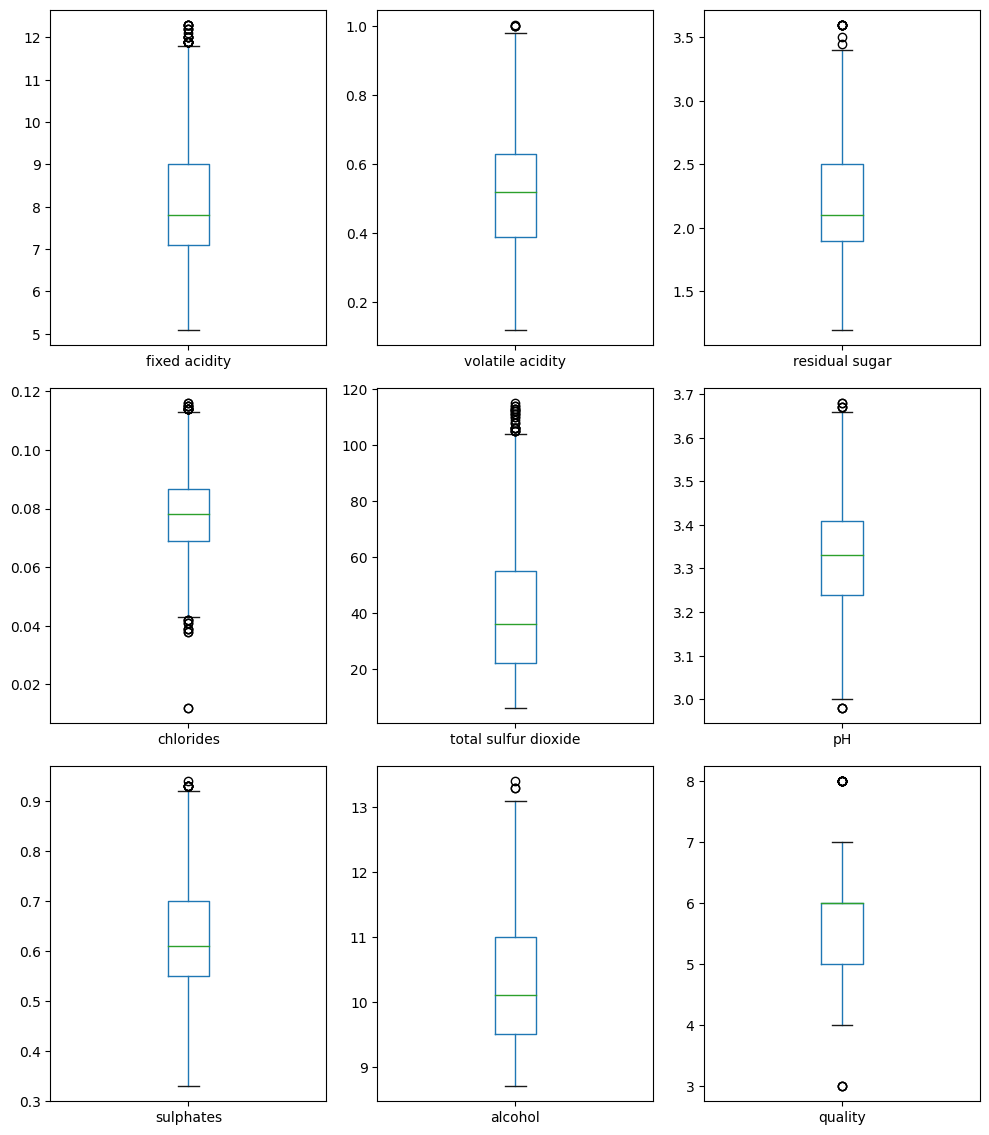

In [37]:
plt.style.use("default")
plt.figure(figsize=(10,15))
for i, col in enumerate(list(wine_dataset.columns.values)):
    plt.subplot(4,3,i+1)
    wine_dataset.boxplot(col)
    plt.grid()
    plt.tight_layout()

A Box Cox transformation is a way to transform non-normal data distribution into a normal shape. Why does it matter?
Because if you are performing a regression or any statistical modeling, this asymmetrical behavior may lead to a bias in the model. If a factor has a significant effect on the average, because the variability is much larger, many factors will seem to have a stronger effect when the mean is larger. This is not due, however, to a true factor effect but rather to an increased amount of variability that affects all factor effect estimates when the mean gets larger. This will probably generate spurious interactions due to a non-constant variation, resulting in a very complex model with many spurious and unrealistic interactions.
Moreover, normality is an important assumption for many statistical techniques. One solution to this is to transform your data into normality using a Box-Cox transformation.
So, after removing outliers, skewness of variables changed. Here the new values:


In [38]:
print("Skewness\n", wine_dataset.skew())

Skewness
 fixed acidity           0.748003
volatile acidity        0.282093
residual sugar          0.625386
chlorides              -0.064911
total sulfur dioxide    0.892078
pH                      0.079758
sulphates               0.513739
alcohol                 0.744075
quality                 0.321122
dtype: float64


It can be seen that there are some variables highly skewed, on which we can apply Box Cox transformation:

In [39]:
from scipy.stats import skew, norm, probplot, boxcox, f_oneway
numeric_features = list(wine_dataset.dtypes[(wine_dataset.dtypes != "str") & (wine_dataset.dtypes !='object')].index)
#numeric_features.remove('color')

skewed_features = wine_dataset[numeric_features].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness = pd.DataFrame({'Skew' :skewed_features})   

# Get only higest skewed features
skewness = skewness[abs(skewness) > 0.7]
skewness = skewness.dropna()
print ("There are {} highest skewed numerical features to box cox transform".format(skewness.shape[0]))

l_opt = {}

for feat in skewness.index:
    wine_dataset[feat], l_opt[feat] = boxcox((wine_dataset[feat]+1))

skewed_features2 = wine_dataset[skewness.index].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness2 = pd.DataFrame({'New Skew' :skewed_features2})   
display(pd.concat([skewness, skewness2], axis=1).sort_values(by=['Skew'], ascending=False))

There are 3 highest skewed numerical features to box cox transform


,Skew,New Skew
total sulfur dioxide,0.890950,-0.022689
fixed acidity,0.747056,0.018871
alcohol,0.743133,0.117989


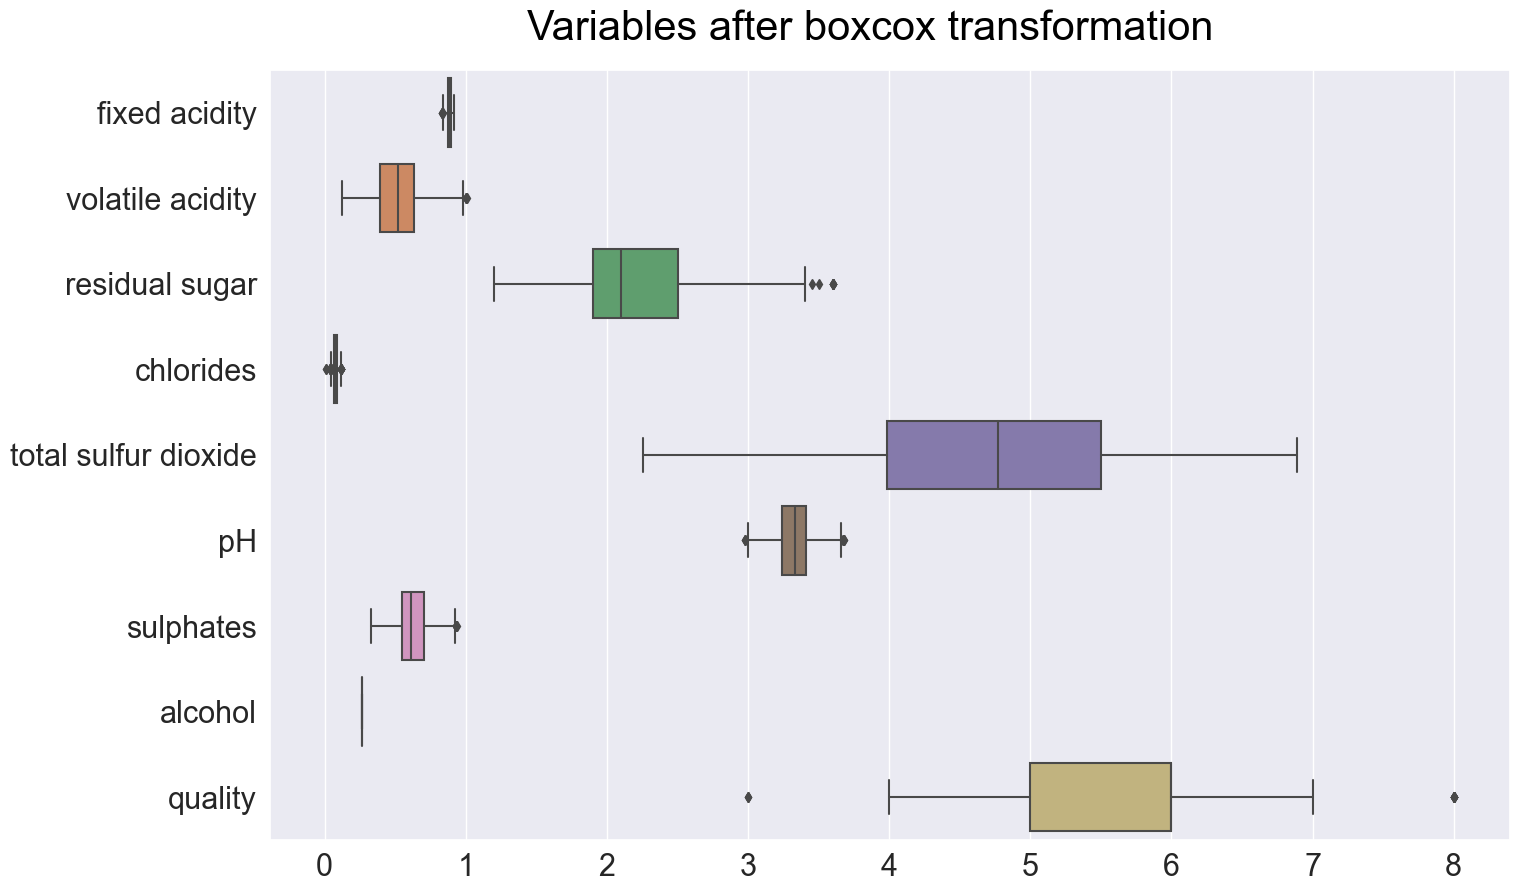

In [40]:
box_plot(wine_dataset, title="Variables after boxcox transformation")

At the end of these data processing steps, the dataset has 1186 rows and 6 columns.

In [41]:
#check shape of final dataset
wine_dataset.shape

(1186, 9)

My input features are Fixed Acidity, Volatile Acidity, Residual Sugar, Chlorides, Total Sulfur Dioxide, pH, Sulphates and Alcohol. My target feature is Quality.

In [42]:
#divide in inputs...
input_columns=list(wine_dataset.columns)[:-1]
input_columns

['fixed acidity',
 'volatile acidity',
 'residual sugar',
 'chlorides',
 'total sulfur dioxide',
 'pH',
 'sulphates',
 'alcohol']

In [43]:
#and output
output_columns = ['quality']
output_columns

['quality']

In [44]:
#make a copy of the dataset
wine_copy = wine_dataset.copy(deep=True)

The class label (for training) is from 3 to 8. Unfortunately if I use these labels with loss_fn,
it will be matched with total 9 labels, (class0 to class8) as maximum class labels is 8. 
So, we need to transform 3 to 8 -> 0 to 5. For loss calculation use: loss = loss_fn(out, targets - 3)
squeeze remove axis of length 1 from the dataframe

In [45]:
#Convert dataframe to numpy arrays
inputs_array = wine_copy[input_columns].to_numpy()
targets_array = (wine_copy[output_columns]-3).to_numpy().squeeze().astype(np.long) 

In [46]:
print(inputs_array.dtype, targets_array.dtype)
targets_array = targets_array.flatten() #1D array to the loss function

float64 int64


In [47]:
#print
print(inputs_array, targets_array)
inputs_array.shape, targets_array.shape

[[0.87482932 0.7        1.9        ... 3.51       0.56       0.26098135]
 [0.88012756 0.88       2.6        ... 3.2        0.68       0.26098581]
 [0.88012756 0.76       2.3        ... 3.26       0.65       0.26098581]
 ...
 [0.85724893 0.51       2.3        ... 3.42       0.75       0.26099533]
 [0.8494589  0.645      2.         ... 3.57       0.71       0.26098953]
 [0.85149029 0.31       3.6        ... 3.39       0.66       0.26099533]] [2 2 2 ... 3 2 3]


((1186, 8), (1186,))

In [48]:
#Convert numpy array to torch tensor
inputs = torch.from_numpy(inputs_array).type(torch.float)
outputs = torch.from_numpy(targets_array).type(torch.long)
inputs, outputs

(tensor([[0.8748, 0.7000, 1.9000,  ..., 3.5100, 0.5600, 0.2610],
         [0.8801, 0.8800, 2.6000,  ..., 3.2000, 0.6800, 0.2610],
         [0.8801, 0.7600, 2.3000,  ..., 3.2600, 0.6500, 0.2610],
         ...,
         [0.8572, 0.5100, 2.3000,  ..., 3.4200, 0.7500, 0.2610],
         [0.8495, 0.6450, 2.0000,  ..., 3.5700, 0.7100, 0.2610],
         [0.8515, 0.3100, 3.6000,  ..., 3.3900, 0.6600, 0.2610]]),
 tensor([2, 2, 2,  ..., 3, 2, 3]))

In [49]:
inputs.shape, outputs.shape

(torch.Size([1186, 8]), torch.Size([1186]))

In [50]:
inputs.dtype, outputs.dtype

(torch.float32, torch.int64)

Next, I converted into a TensorDataset my inputs and outputs, and now that I have a single dataset, I could split in training set and validation set. I used the 20% of the entire dataset as validation, so at the end I had 949 examples for the training set and 237 for the validation set. To ensure that we always create the same validation set, we also set a seed for the random number generator. 


In [51]:
#Create a Tensor Dataset
WineTensorDataset = TensorDataset(inputs, outputs)
WineTensorDataset

In [52]:
#I split in 80% train and 20% val
num_rows = len(wine_copy)
val_percent = 0.2 
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

random_seed = 42
torch.manual_seed(random_seed)
#To ensure that we always create the same validation set, we'll also set a seed for the random number generator.

train_df, val_df = random_split(WineTensorDataset, [train_size, val_size]) 
len(train_df), len(val_df)

(949, 237)

In [53]:
#This 2 cells counts the number of occurrence per each class in the training set. 
#I will probably use this information in the second part of the experiment
batch_size=949
training_loader = DataLoader(train_df, batch_size)

In [54]:
from collections import Counter
training_loader
for xb, yb in training_loader:
    #print("inputs:", xb)
    #print("outputs:", yb)
    counter0 = 0
    counter1 = 0
    counter2 = 0
    counter3 = 0
    counter4 = 0
    counter5 = 0
    for i in range(0, 949):
        if yb[i].item()==0:
            counter0 = counter0+1
        elif yb[i].item()==1:
            counter1 = counter1+1  
        elif yb[i].item()==2:
            counter2 = counter2+1
        elif yb[i].item()==3:
            counter3 = counter3+1
        elif yb[i].item()==4:
            counter4 = counter4+1
        elif yb[i].item()==5:
            counter5 = counter5+1    
    print("Quality 3 = ", counter0, "Weight for loss (highest counter/class counter)=", counter2/counter0)
    print("Quality 4 = ", counter1, "Weight for loss (highest counter/class counter)=", counter2/counter1)
    print("Quality 5 = ", counter2, "Weight for loss (highest counter/class counter)=", counter2/counter2)
    print("Quality 6 = ", counter3, "Weight for loss (highest counter/class counter)=", counter2/counter3)
    print("Quality 7 = ", counter4, "Weight for loss (highest counter/class counter)=", counter2/counter4)
    print("Quality 8 = ", counter5, "Weight for loss (highest counter/class counter)=", counter2/counter5)
    break

Quality 3 =  3 Weight for loss (highest counter/class counter)= 135.0
Quality 4 =  27 Weight for loss (highest counter/class counter)= 15.0
Quality 5 =  405 Weight for loss (highest counter/class counter)= 1.0
Quality 6 =  393 Weight for loss (highest counter/class counter)= 1.0305343511450382
Quality 7 =  112 Weight for loss (highest counter/class counter)= 3.6160714285714284
Quality 8 =  9 Weight for loss (highest counter/class counter)= 45.0


Next, I initialized batch size to 64. The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.
Then I used the DataLoader class, that represent a Python iterable over a dataset. It combines a dataset and a sampler, and yields data as a batch for every epoch.
The parameter shuffle = True shuffle the data while training, so that inputs and outputs are collected in a rearranged or intermixed manner from the dataset for each batch. This randomization helps and generalize and speed up the training process.

In [55]:
#Pick a batch size for DataLoader
batch_size=64
train_loader = DataLoader(train_df, batch_size, shuffle=True)
val_loader = DataLoader(val_df, batch_size)

Finally, I defined a DeviceDataLoader class to wrap our existing data loaders and move batches of data to the selected device. Tensors moved to the GPU have a device property which includes that word cuda.

In [56]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [57]:
device = get_default_device()
device

device(type='cpu')

In [58]:
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)

Let's print a batch of data

In [59]:
for xb, yb in train_dl:
    print("inputs:", xb)
    print("outputs:", yb)
    break

inputs: tensor([[0.8775, 0.4900, 1.9000, 0.0740, 6.3002, 3.4100, 0.5800, 0.2610],
        [0.9024, 0.4800, 2.7000, 0.1020, 4.5764, 3.2800, 0.5600, 0.2610],
        [0.8826, 0.5200, 2.0000, 0.0780, 5.6236, 3.3000, 0.4800, 0.2610],
        [0.8826, 0.6000, 2.1000, 0.0800, 6.7101, 3.3000, 0.4900, 0.2610],
        [0.8826, 0.5900, 2.0000, 0.0890, 4.5764, 3.3600, 0.6100, 0.2610],
        [0.8705, 0.6100, 2.5000, 0.0810, 6.3447, 3.4800, 0.6000, 0.2610],
        [0.8788, 0.5700, 1.5000, 0.0690, 2.7423, 3.1600, 0.5400, 0.2610],
        [0.8990, 0.7700, 2.9000, 0.0820, 6.0387, 3.3000, 0.6400, 0.2610],
        [0.8826, 0.6200, 2.8000, 0.0860, 5.3986, 3.3100, 0.6200, 0.2610],
        [0.8850, 0.5700, 2.2000, 0.0600, 5.7992, 3.3000, 0.4300, 0.2610],
        [0.9154, 0.3900, 2.8000, 0.0950, 4.7231, 3.1000, 0.6100, 0.2610],
        [0.9032, 0.4300, 2.6000, 0.0920, 5.3986, 3.2200, 0.6400, 0.2610],
        [0.8826, 0.3800, 1.8000, 0.0780, 5.2944, 3.3700, 0.5200, 0.2610],
        [0.8748, 0.6600, 1.800

Now I define the input size and the output size of my Neural Network, that are respectively the number of neurons of the input layer and of the output layer. The reason why I am using 6 as number of output size is in the next cell.

In [60]:
input_size = len(input_columns)
output_size = 6
print(input_size)
print(output_size)

8
6


The loss measure used is the Cross-Entropy Loss. Cross-entropy is a commonly used loss function for classification tasks. The prediction is a probability vector, meaning it represents predicted probabilities of all classes, summing up to 1. This method combines the Softmax activation function principle and the negative log likelihood loss.
In a neural network, you typically achieve this prediction by having the last layer activated by a softmax function, but anything goes — it just must be a probability vector.     
Loss is a measure of performance of a model. The lower, the better. When learning, the model aims to get the lowest loss possible.
The target represents probabilities for all classes — 3 to 8 quality.
The target for multi-class classification is a one-hot vector, meaning it has 1 on a single position and 0’s everywhere else.
For example, for the 3rd class, we want the probability to be 1. For other classes, we want it to be 0.

In [61]:
#Loss function
loss_fn = F.cross_entropy

In the cell above there is the implementation of the neural network. Information move from the initial 8 input nodes, that are the features, to the last layer with 6 output nodes, that are the predicted classes of quality. In between I put 3 hidden layers, the first one with 32 neurons, the second one with 64 and the last one with 32. I chose this architecture after doing several trials.
In each hidden layer I used the non-linear activation function PReLU, that is similar to the ReLU, but with the advantage that his derivative is different from zero when the variable is negative. We need activation functions otherwise each layer will be only the linear function of its input features, and a linear hidden layer is more or less useless.
Then, in 2 hidden layers I used Dropout, that is a regularization technique to prevent overfitting. With Dropout I set a probability of eliminating (zeroing out) a node in that layer of NN.
All the elements of this NN are contained in the class WineQuality, that contains several methods.
Everything which contains weights which you want to be trained during the training process should be defined in your __init__ method.
Then, I use these things in the forward method for doing forward propagation.
The other methods are used to generate predictions and to calculate loss of training and validation steps, and to combine losses and accuracies and print them.

In [62]:
class WineQuality(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            #input to first hidden layer
            nn.Linear(input_size, 32),
            nn.PReLU(),
            #first to second hidden layer
            nn.Linear(32, 64),
            nn.Dropout(0.5),
            nn.PReLU(),
            #second to third hidden layer
            nn.Linear(64, 32),
            nn.Dropout(0.5),
            nn.PReLU(),
            #third to 4th hidden layer
            nn.Linear(32, output_size)
        )
        
    def forward(self, xb): 
        return self.net(xb)
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs) 
        # Calcuate loss
        loss = loss_fn(out, targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = loss_fn(out, targets)
        acc = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        # Print result every 100th epoch
        #if (epoch+1) % 100 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], 
                                                        result['val_loss'], result['val_acc']))

In [63]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Let us create a object of WineQuality model.

In [64]:
model = WineQuality()
model.to(device)
model

WineQuality(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): PReLU(num_parameters=1)
    (5): Linear(in_features=64, out_features=32, bias=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): PReLU(num_parameters=1)
    (8): Linear(in_features=32, out_features=6, bias=True)
  )
)

In the cell below we can see the weights and biases of the NN.

In [65]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.1256,  0.2509, -0.2251,  0.2147,  0.2205,  0.1951,  0.3394,  0.0535],
         [-0.3205,  0.2524,  0.0324,  0.0070, -0.3368, -0.0795, -0.1716,  0.3463],
         [ 0.2517,  0.2637,  0.2421, -0.2192, -0.1518, -0.1384, -0.1417,  0.2752],
         [ 0.1201,  0.2833, -0.0165, -0.3152, -0.1026,  0.2485,  0.2152,  0.1095],
         [-0.1037, -0.3300, -0.1900,  0.1843, -0.1426,  0.1691,  0.0965, -0.1358],
         [ 0.2153, -0.1136, -0.0117, -0.1347, -0.3354,  0.0570,  0.1022, -0.1780],
         [ 0.2169, -0.3172, -0.3408, -0.2184, -0.1222, -0.0393, -0.0683,  0.1614],
         [-0.3103,  0.0521,  0.0061,  0.0934,  0.3515,  0.2176, -0.1958, -0.2897],
         [-0.0856, -0.1774,  0.1235,  0.0032,  0.2844,  0.1389, -0.0650,  0.0122],
         [ 0.0847, -0.0439,  0.2853, -0.2764,  0.1723, -0.2254, -0.3097, -0.0726],
         [ 0.1723,  0.2498,  0.0887, -0.0306, -0.0198, -0.1433, -0.0317, -0.0244],
         [ 0.3009,  0.2069, -0.2829,  0.0015, -0.2175, -0.0561, 

Now I'll define an evaluate function, which will perform the validation phase, a fit function which will perform the entire training process, and a get_lr function that will be used inside of the fit function.
Before training the model, let's see the fit function. It contains different techniques to do hyperparameter optimization, to prevent overfitting, and to avoid exploding gradients.

Learning rate scheduling: Instead of using a fixed learning rate, I will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one I'll use is called the "One Cycle Learning Rate Policy", which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. 

Weight decay: I also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function. 

Gradient clipping: Apart from the layer weights and outputs, it is also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. 


In [66]:
def evaluate(model, val_loader):
    #model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we begin training, let's see how the model performs on the validation set with the initial set of parameters.

In [67]:
history = evaluate(model, valid_dl)
history

{'val_loss': 1.7637394666671753, 'val_acc': 0.13593749701976776}

The initial accuracy is low, which is what one might expect from a randomly intialized model.

We'll use the following hyperparmeters (max learning rate, no. of epochs, grad_clip, weight decay, batch_size etc.) to train our model. 
Instead of SGD (stochastic gradient descent), we'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates (RMSProp) for faster training. 

In [68]:
epochs = 25
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [69]:
%%time
history = fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00077, train_loss: 1.6840, val_loss: 1.5795, val_acc: 0.4069
Epoch [1], last_lr: 0.00192, train_loss: 1.4170, val_loss: 1.3326, val_acc: 0.4214
Epoch [2], last_lr: 0.00364, train_loss: 1.2421, val_loss: 1.1925, val_acc: 0.4499
Epoch [3], last_lr: 0.00564, train_loss: 1.2065, val_loss: 1.1795, val_acc: 0.4516
Epoch [4], last_lr: 0.00756, train_loss: 1.1795, val_loss: 1.2169, val_acc: 0.4014
Epoch [5], last_lr: 0.00907, train_loss: 1.1738, val_loss: 1.1929, val_acc: 0.4193
Epoch [6], last_lr: 0.00989, train_loss: 1.1700, val_loss: 1.1735, val_acc: 0.4248
Epoch [7], last_lr: 0.00998, train_loss: 1.1519, val_loss: 1.1662, val_acc: 0.5213
Epoch [8], last_lr: 0.00982, train_loss: 1.1436, val_loss: 1.1696, val_acc: 0.4220
Epoch [9], last_lr: 0.00950, train_loss: 1.1385, val_loss: 1.1238, val_acc: 0.4832
Epoch [10], last_lr: 0.00905, train_loss: 1.1189, val_loss: 1.2166, val_acc: 0.4487
Epoch [11], last_lr: 0.00846, train_loss: 1.1388, val_loss: 1.0824, val_acc: 0.5095
Ep

In [70]:
result = evaluate(model, valid_dl)

We can now plot the losses & accuracies to study how the model improves over time.

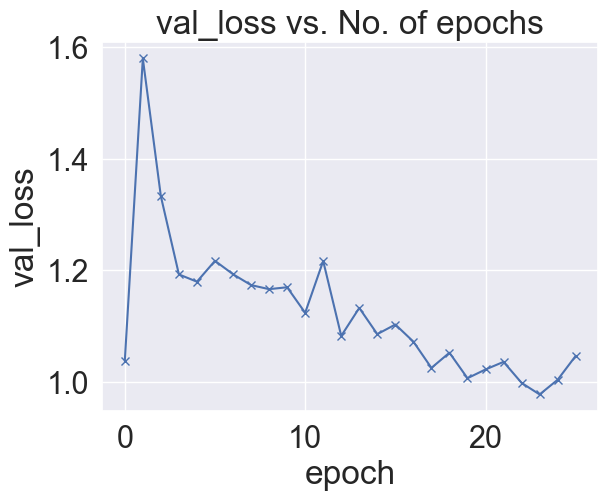

In [71]:
plt.title('val_loss vs. No. of epochs');
loss_mat = [res['val_loss'] for res in [result] + history]
plt.plot(loss_mat, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')

val_loss = loss_mat[-1]

While the accuracy does continue to increase as we train for more epochs, the improvements get smaller with every epoch. Let's visualize this using a line graph.


In [72]:
def plot_accuracies(history):
    accuracies = [x['val_acc']*100 for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('% accuracy')
    plt.title('Accuracy vs. No. of epochs');

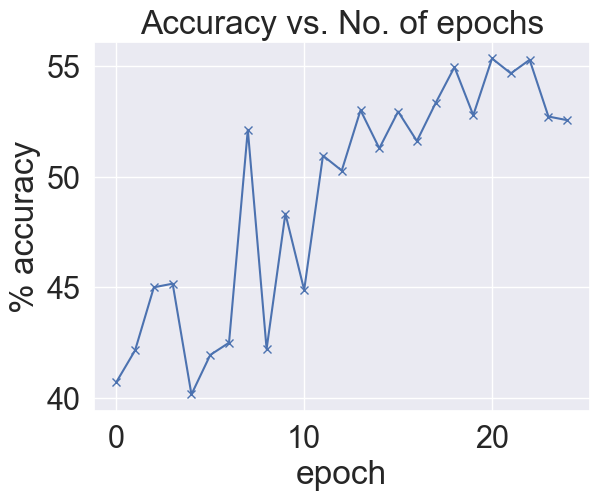

In [73]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend.

In [74]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

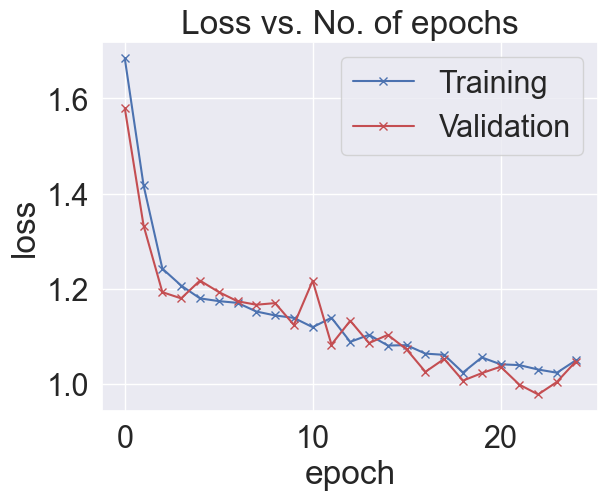

In [75]:
plot_losses(history)

In [76]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

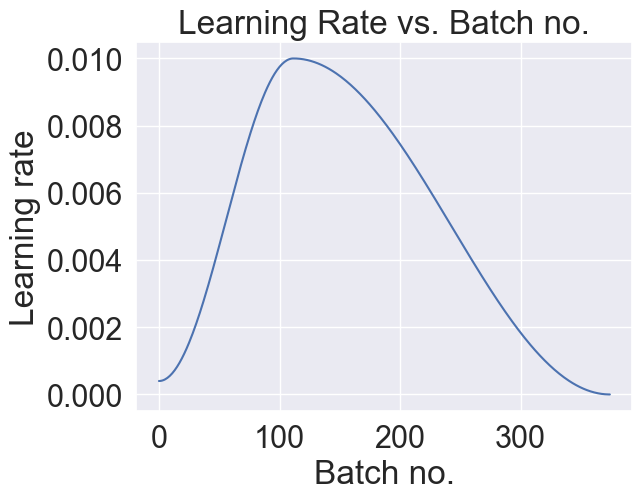

In [77]:
plot_lrs(history)

After these graphs we can understand that the model doesn’t learn nicely after such operations, but it started to output the class that happens to be the most frequent one in the dataset. This is because our dataset is too much unbalanced, so the model does not learn well.
Now we can do some predictions on a single example, and then on a batch size. We see again that the model will predict the most present classes in the dataset.

In [78]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target+3)
    print("Prediction (logits):", prediction)
    return prediction

In [79]:
import warnings
warnings.filterwarnings("ignore")

input, target = val_df[0]
prediction = predict_single(input, target, model)
prediction = F.softmax(prediction)
print("Prediction (probabilities):", prediction)
output = model(input.unsqueeze(0))
pred = output.argmax(1)
print("Predicted class (-3):", pred)
pred=pred+3
print("Predicted class:", pred.item())

Input: tensor([0.8626, 0.5700, 2.1000, 0.1150, 3.5177, 3.3800, 0.6900, 0.2610])
Target: tensor(5)
Prediction (logits): tensor([-4.1822, -1.9769,  1.1256,  1.7021,  0.9571, -2.1787])
Prediction (probabilities): tensor([0.0013, 0.0121, 0.2694, 0.4796, 0.2277, 0.0099])
Predicted class (-3): tensor([3])
Predicted class: 6


In [80]:
def predict_batch():
    for i, (input, target) in enumerate(val_loader):
        inputs = input
        targets = target
        print("Targets:", targets)
        predictions = model(inputs)
        print("Prediction (logits):", predictions)
        prediction = F.softmax(predictions)
        print("Prediction (probabilities):", prediction)
        output = model(inputs)
        pred = output.argmax(1)
        pred=pred+3
        print("Predicted class:", pred)
        break     

In [81]:
predict_batch()

Targets: tensor([2, 2, 3, 2, 3, 2, 2, 3, 3, 4, 2, 1, 3, 3, 1, 3, 4, 3, 2, 3, 3, 2, 2, 2,
        4, 2, 2, 2, 4, 3, 3, 2, 3, 3, 2, 2, 2, 4, 2, 3, 3, 2, 3, 4, 2, 2, 3, 3,
        3, 3, 4, 3, 2, 3, 2, 4, 2, 4, 3, 2, 3, 3, 2, 3])
Prediction (logits): tensor([[-2.3123, -0.7327,  1.1552,  1.1304,  0.0617, -1.6264],
        [-2.3184, -0.8319,  1.1364,  1.0313, -0.1397, -1.8303],
        [-6.1383, -1.7721,  3.0027,  2.6432,  0.0693, -4.2597],
        [-3.0062, -1.1371,  1.3498,  1.3559, -0.2791, -2.6085],
        [-3.7778, -1.0740,  1.9477,  1.7849, -0.9390, -3.4244],
        [-1.2908,  1.0971,  2.6915,  1.2977, -1.7304, -2.2891],
        [-3.8092, -0.9529,  1.6817,  1.4562, -0.4855, -2.8167],
        [-0.9746,  1.7140,  2.8644,  1.0809, -2.7072, -3.2903],
        [-7.8104, -4.1015,  0.4304,  2.7429,  2.9907, -2.1509],
        [-5.4164, -3.4842,  0.1869,  2.1174,  1.6741, -2.0913],
        [-1.3814, -0.2083,  1.4175,  0.7920, -1.0578, -1.5638],
        [-1.3210,  0.5356,  2.0504,  0.9101, -1.2

We have understood that this model reaches only about 50% of accuracy, and we know that the dataset is imbalanced. So, I used the oversampling technique of SMOTE to try to obtain better results. I performed SMOTE on the platform Microsoft Azure Machine Learning.
Another option, equivalent to oversampling, was the class weighting, which consists in passing as argument to the Cross Entropy Loss a tensor of weights, in which the weight of class c is equal to the size of the largest class divided by the size of class c. 
Weighting classes is also better from storage and computational point of view since it avoids working with a larger data-set, but I used SMOTE because in this case the dataset was very small.
So, I will read the new dataset and perform the data prep in a single cell.

There are 1 highest skewed numerical features to box cox transform


,Skew,New Skew
total sulfur dioxide,1.109706,0.01204


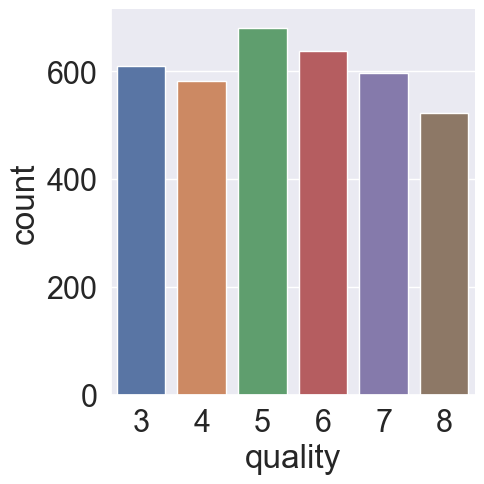

In [82]:
wine_dataset = pd.read_csv("/Users/Casella/Documents/DATA SCIENCE/2 ANNO/NEURAL COMPUTING/PROJECT/Exams_wine_wine_smote.csv")
wine_dataset.quality.value_counts()
sns.catplot(x='quality', data=wine_dataset, kind='count')
wine_dataset = wine_dataset.drop(columns=['citric acid','density','free sulfur dioxide'])
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["fixed acidity"]>12.349999999999998].index)
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["volatile acidity"]>1.0075].index)
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["residual sugar"]>3.6500000000000004].index)
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["chlorides"]>0.11750000000000002].index)
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["total sulfur dioxide"]>115.5].index)
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["pH"]>3.68].index)
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["pH"]<2.96].index)
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["sulphates"]>0.9499999999999998].index)
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["alcohol"]>13.458333333333375].index)
from scipy.stats import skew, norm, probplot, boxcox, f_oneway
numeric_features = list(wine_dataset.dtypes[(wine_dataset.dtypes != "str") & (wine_dataset.dtypes !='object')].index)
#numeric_features.remove('color')

skewed_features = wine_dataset[numeric_features].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness = pd.DataFrame({'Skew' :skewed_features})   

# Get only higest skewed features
skewness = skewness[abs(skewness) > 0.7]
skewness = skewness.dropna()
print ("There are {} highest skewed numerical features to box cox transform".format(skewness.shape[0]))

l_opt = {}

for feat in skewness.index:
    wine_dataset[feat], l_opt[feat] = boxcox((wine_dataset[feat]+1))

skewed_features2 = wine_dataset[skewness.index].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)
#compute skewness
skewness2 = pd.DataFrame({'New Skew' :skewed_features2})   
display(pd.concat([skewness, skewness2], axis=1).sort_values(by=['Skew'], ascending=False))
#check shape of final dataset
wine_dataset.shape
#divide in inputs...
input_columns=list(wine_dataset.columns)[:-1]
#and output
output_columns = ['quality']
#make a copy of the dataset
wine_copy = wine_dataset.copy(deep=True)
#Convert dataframe to numpy arrays
inputs_array = wine_copy[input_columns].to_numpy()
targets_array = (wine_copy[output_columns]-3).to_numpy().squeeze().astype(np.long) 
#Convert numpy array to torch tensor
inputs = torch.from_numpy(inputs_array).type(torch.float)
outputs = torch.from_numpy(targets_array).type(torch.long)
#Create a Tensor Dataset
WineTensorDataset = TensorDataset(inputs, outputs)
WineTensorDataset

#I split in 80% train and 20% val
num_rows = len(wine_copy)
val_percent = 0.2 
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

random_seed = 42
torch.manual_seed(random_seed)
#To ensure that we always create the same validation set, we'll also set a seed for the random number generator.

train_df, val_df = random_split(WineTensorDataset, [train_size, val_size]) 
len(train_df), len(val_df)

#Pick a batch size for DataLoader
batch_size=64
train_loader = DataLoader(train_df, batch_size, shuffle=True)
val_loader = DataLoader(val_df, batch_size)
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)

In [83]:
#If we used weighting classes, we could use these weights for example
#weights = torch.tensor([134.66666666666666, 14.428571428571429, 1.0, 1.015075376884422, 3.8846153846153846, 33.666666666666664])

#Loss function
loss_fn = F.cross_entropy

In [84]:
class WineQuality(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            #input to first hidden layer
            nn.Linear(input_size, 32),
            nn.PReLU(),
            #first to second hidden layer
            nn.Linear(32, 64),
            nn.Dropout(0.5),
            nn.PReLU(),
            #second to third hidden layer
            nn.Linear(64, 32),
            nn.Dropout(0.5),
            nn.PReLU(),
            #third to 4th hidden layer
            nn.Linear(32, output_size)
        )
        
    def forward(self, xb): 
        return self.net(xb)
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs) 
        # Calcuate loss
        loss = loss_fn(out, targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = loss_fn(out, targets)
        acc = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        # Print result every 100th epoch
        #if (epoch+1) % 100 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], 
                                                        result['val_loss'], result['val_acc']))

In [85]:
new_model = WineQuality()
new_model.to(device)
new_model

WineQuality(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): PReLU(num_parameters=1)
    (5): Linear(in_features=64, out_features=32, bias=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): PReLU(num_parameters=1)
    (8): Linear(in_features=32, out_features=6, bias=True)
  )
)

In [86]:
history = evaluate(new_model, valid_dl)
history

{'val_loss': 1.8258535861968994, 'val_acc': 0.1868106573820114}

In [87]:
epochs = 50
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [88]:
%%time
history = fit_one_cycle(epochs, max_lr, new_model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00050, train_loss: 1.7942, val_loss: 1.7910, val_acc: 0.1878
Epoch [1], last_lr: 0.00080, train_loss: 1.7865, val_loss: 1.7673, val_acc: 0.2074
Epoch [2], last_lr: 0.00130, train_loss: 1.7591, val_loss: 1.7661, val_acc: 0.2132
Epoch [3], last_lr: 0.00197, train_loss: 1.7595, val_loss: 1.7661, val_acc: 0.1824
Epoch [4], last_lr: 0.00278, train_loss: 1.7335, val_loss: 1.7552, val_acc: 0.2382
Epoch [5], last_lr: 0.00370, train_loss: 1.7135, val_loss: 1.6827, val_acc: 0.2675
Epoch [6], last_lr: 0.00468, train_loss: 1.5907, val_loss: 1.5003, val_acc: 0.3273
Epoch [7], last_lr: 0.00569, train_loss: 1.4284, val_loss: 1.3756, val_acc: 0.3659
Epoch [8], last_lr: 0.00667, train_loss: 1.3723, val_loss: 1.4088, val_acc: 0.3642
Epoch [9], last_lr: 0.00759, train_loss: 1.3793, val_loss: 1.3528, val_acc: 0.3973
Epoch [10], last_lr: 0.00841, train_loss: 1.3584, val_loss: 1.4360, val_acc: 0.3625
Epoch [11], last_lr: 0.00908, train_loss: 1.3632, val_loss: 1.3390, val_acc: 0.3955
Ep

In [89]:
result = evaluate(new_model, valid_dl)

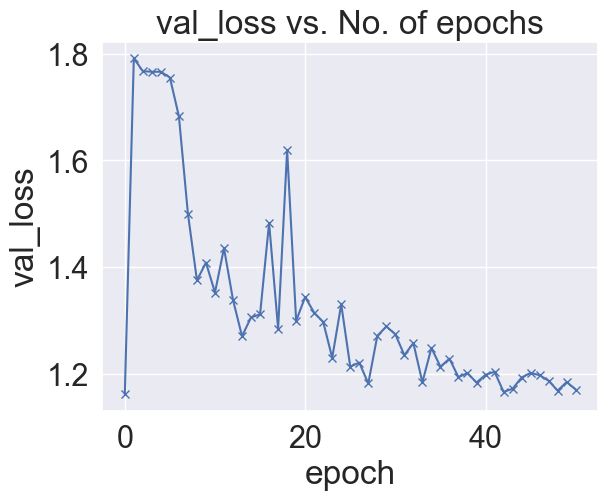

In [90]:
plt.title('val_loss vs. No. of epochs');
loss_mat = [res['val_loss'] for res in [result] + history]
plt.plot(loss_mat, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')

val_loss = loss_mat[-1]

In [91]:
import warnings
warnings.filterwarnings("ignore")

input, target = val_df[0]
prediction = predict_single(input, target, new_model)
prediction = F.softmax(prediction)
print("Prediction (probabilities):", prediction)
output = new_model(input.unsqueeze(0))
pred = output.argmax(1)
print("Predicted class (-3):", pred)
pred=pred+3
print("Predicted class:", pred.item())

Input: tensor([ 7.5828,  0.3362,  1.7692,  0.0668,  2.6050,  3.2250,  0.8903, 11.6655])
Target: tensor(8)
Prediction (logits): tensor([-8.4125, -5.5694, -1.2872,  1.6220,  4.6969,  5.2533])
Prediction (probabilities): tensor([7.2541e-07, 1.2454e-05, 9.0163e-04, 1.6539e-02, 3.5801e-01, 6.2454e-01])
Predicted class (-3): tensor([5])
Predicted class: 8


In [92]:
predict_batch()

Targets: tensor([5, 5, 4, 2, 4, 5, 5, 5, 3, 5, 0, 1, 2, 5, 3, 1, 4, 3, 4, 0, 4, 3, 3, 2,
        3, 2, 4, 3, 4, 5, 4, 5, 3, 5, 2, 2, 4, 4, 1, 2, 4, 4, 2, 5, 1, 5, 4, 3,
        3, 3, 0, 4, 1, 0, 5, 4, 3, 5, 3, 3, 0, 3, 4, 4])
Prediction (logits): tensor([[ 1.1215e+01,  5.5604e+00, -2.8556e+00, -3.4233e+00, -2.0717e+00,
          6.7056e+00],
        [ 5.5592e+00,  3.2856e+00, -9.6292e-01, -1.2822e+00, -1.6257e+00,
          3.5324e+00],
        [ 1.9894e+01,  1.1130e+01, -3.7996e+00, -6.2012e+00, -4.0517e+00,
          1.2121e+01],
        [ 8.1018e+00,  6.1308e+00,  1.6802e+00, -1.5787e+00, -6.0074e+00,
          2.3598e+00],
        [ 1.3593e+01,  5.8576e+00, -3.2805e+00, -4.2156e+00, -1.4120e+00,
          8.4345e+00],
        [ 1.3587e+01,  7.8194e+00, -1.7168e+00, -3.5274e+00, -3.9641e+00,
          7.6273e+00],
        [ 1.7787e+01,  9.2342e+00, -2.3225e+00, -4.5986e+00, -3.8176e+00,
          1.0783e+01],
        [ 1.6979e+01,  7.3870e+00, -3.3601e+00, -4.9545e+00, -3.1829e+00,


In [93]:
output

tensor([[-6.7710, -3.3665, -0.6439,  1.2837,  3.2603,  3.3990]],
       grad_fn=<AddmmBackward>)

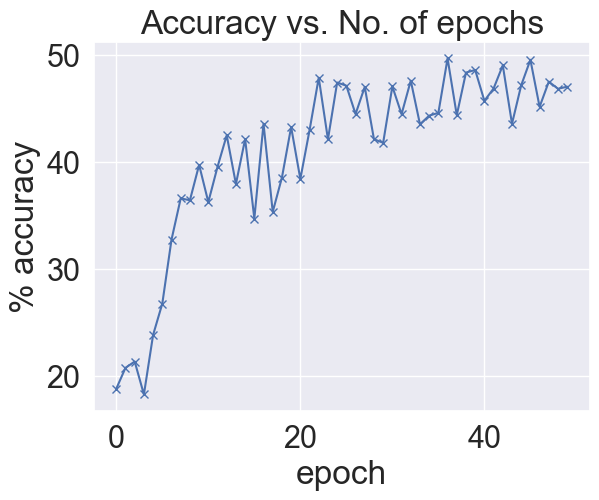

In [94]:
plot_accuracies(history)

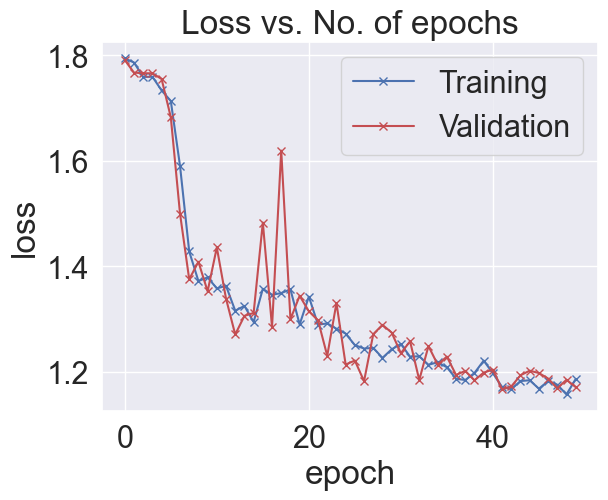

In [95]:
plot_losses(history)

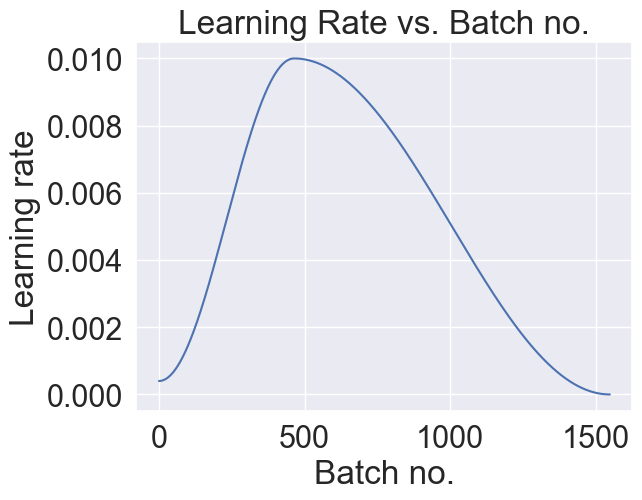

In [96]:
plot_lrs(history)

Finally, also with a balanced dataset, the results in terms of accuracy and loss do not improve so much. I tried also with weighting classes, but both these solutions failed. So now I will do the last experiment in order to obtain better results.

Now, I wanna treat my problem as a regression problem. So I will create a Linear Regression Model, using the L1 Loss, and 1 as output_size. I used also a simpler model and less evaluation terms, to go faster.

There are 3 highest skewed numerical features to box cox transform


,Skew,New Skew
total sulfur dioxide,0.890950,-0.022689
fixed acidity,0.747056,0.018871
alcohol,0.743133,0.117989


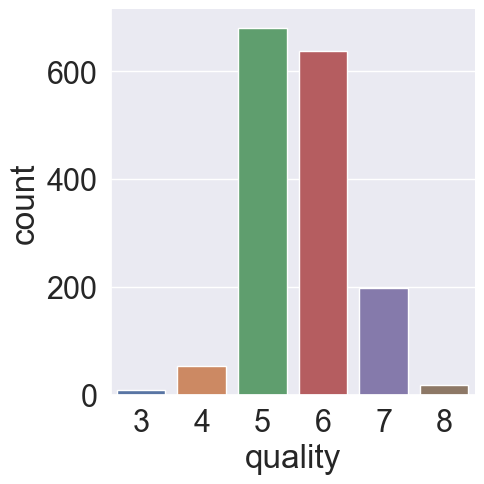

In [97]:
wine_dataset = pd.read_csv("/Users/Casella/Documents/DATA SCIENCE/2 ANNO/NEURAL COMPUTING/PROJECT/Exams_wine_wine.csv")
wine_dataset.quality.value_counts()
sns.catplot(x='quality', data=wine_dataset, kind='count')
wine_dataset = wine_dataset.drop(columns=['citric acid','density','free sulfur dioxide'])
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["fixed acidity"]>12.349999999999998].index)
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["volatile acidity"]>1.0075].index)
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["residual sugar"]>3.6500000000000004].index)
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["chlorides"]>0.11750000000000002].index)
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["total sulfur dioxide"]>115.5].index)
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["pH"]>3.68].index)
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["pH"]<2.96].index)
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["sulphates"]>0.9499999999999998].index)
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["alcohol"]>13.458333333333375].index)
from scipy.stats import skew, norm, probplot, boxcox, f_oneway
numeric_features = list(wine_dataset.dtypes[(wine_dataset.dtypes != "str") & (wine_dataset.dtypes !='object')].index)
#numeric_features.remove('color')

skewed_features = wine_dataset[numeric_features].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness = pd.DataFrame({'Skew' :skewed_features})   

# Get only higest skewed features
skewness = skewness[abs(skewness) > 0.7]
skewness = skewness.dropna()
print ("There are {} highest skewed numerical features to box cox transform".format(skewness.shape[0]))

l_opt = {}

for feat in skewness.index:
    wine_dataset[feat], l_opt[feat] = boxcox((wine_dataset[feat]+1))

skewed_features2 = wine_dataset[skewness.index].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)
#compute skewness
skewness2 = pd.DataFrame({'New Skew' :skewed_features2})   
display(pd.concat([skewness, skewness2], axis=1).sort_values(by=['Skew'], ascending=False))
#check shape of final dataset
wine_dataset.shape
#divide in inputs...
input_columns=list(wine_dataset.columns)[:-1]
#and output
output_columns = ['quality']
#make a copy of the dataset
wine_copy = wine_dataset.copy(deep=True)
#Convert dataframe to numpy arrays
inputs_array = wine_copy[input_columns].to_numpy()
targets_array = (wine_copy[output_columns]).to_numpy()
#Convert numpy array to torch tensor
inputs = torch.from_numpy(inputs_array).type(torch.float)
outputs = torch.from_numpy(targets_array).type(torch.float)
#Create a Tensor Dataset
WineTensorDataset = TensorDataset(inputs, outputs)
WineTensorDataset

#I split in 80% train and 20% val
num_rows = len(wine_copy)
val_percent = 0.2 
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

random_seed = 42
torch.manual_seed(random_seed)
#To ensure that we always create the same validation set, we'll also set a seed for the random number generator.

train_df, val_df = random_split(WineTensorDataset, [train_size, val_size]) 
len(train_df), len(val_df)

#Pick a batch size for DataLoader
batch_size=64
train_loader = DataLoader(train_df, batch_size, shuffle=True)
val_loader = DataLoader(val_df, batch_size)
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)

In [98]:
input_size = len(input_columns)
output_size = len(output_columns)
#Loss function
loss_fn = F.l1_loss

In [99]:
class WineQuality(nn.Module):
    def __init__(self):
        super().__init__()  
        self.net = nn.Sequential(
            #input to first hidden layer
            nn.Linear(input_size, 14),
            nn.PReLU(),
            #first to output
            nn.Linear(14, output_size))
            
        
    def forward(self, xb): 
        #out = self.linear(xb)                       
        return self.net(xb)
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out,targets) 
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out,targets)                        
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 100th epoch
        if (epoch+1) % 100 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [100]:
new_model=WineQuality()
new_model

WineQuality(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=14, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=14, out_features=1, bias=True)
  )
)

In [101]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [102]:
#model=WineQuality()
epochs = 1500
lr = 1e-4
history5 = fit(epochs, lr, new_model, train_loader, val_loader)

Epoch [100], val_loss: 1.7423
Epoch [200], val_loss: 0.9897
Epoch [300], val_loss: 0.9503
Epoch [400], val_loss: 0.9142
Epoch [500], val_loss: 0.8841
Epoch [600], val_loss: 0.8566
Epoch [700], val_loss: 0.8322
Epoch [800], val_loss: 0.8087
Epoch [900], val_loss: 0.7865
Epoch [1000], val_loss: 0.7680
Epoch [1100], val_loss: 0.7516
Epoch [1200], val_loss: 0.7367
Epoch [1300], val_loss: 0.7237
Epoch [1400], val_loss: 0.7116
Epoch [1500], val_loss: 0.7005


In [103]:
#model=WineQuality()
epochs = 1500
lr = 1e-5
history5 += fit(epochs, lr, new_model, train_loader, val_loader)

Epoch [100], val_loss: 0.6995
Epoch [200], val_loss: 0.6985
Epoch [300], val_loss: 0.6974
Epoch [400], val_loss: 0.6963
Epoch [500], val_loss: 0.6953
Epoch [600], val_loss: 0.6942
Epoch [700], val_loss: 0.6932
Epoch [800], val_loss: 0.6921
Epoch [900], val_loss: 0.6910
Epoch [1000], val_loss: 0.6900
Epoch [1100], val_loss: 0.6889
Epoch [1200], val_loss: 0.6879
Epoch [1300], val_loss: 0.6869
Epoch [1400], val_loss: 0.6859
Epoch [1500], val_loss: 0.6850


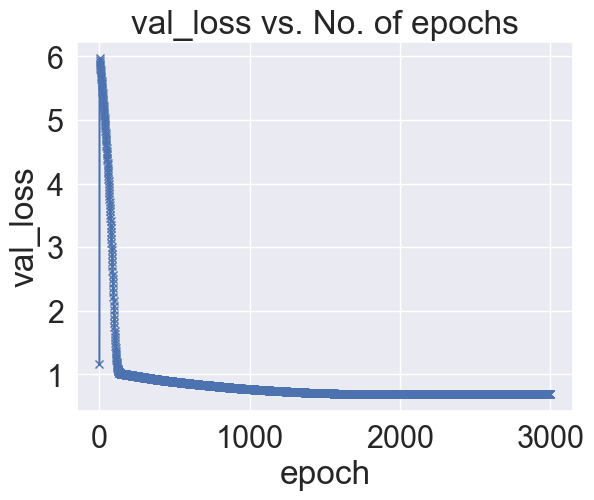

In [104]:
plt.title('val_loss vs. No. of epochs');
loss_mat = [res['val_loss'] for res in [result] + history5]
plt.plot(loss_mat, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')

val_loss = loss_mat[-1]

In [105]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = new_model(inputs)
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [106]:
input, target = val_df[0]
predict_single(input, target, model)

Input: tensor([0.8626, 0.5700, 2.1000, 0.1150, 3.5177, 3.3800, 0.6900, 0.2610])
Target: tensor([5.])
Prediction: tensor([5.4170])


Here you can see quality of wine is 5. and our model is predicting 5.4455 which is pretty close. You can try other samples and get the accuracy of prediction.

For further works, it can be nice to continue working on the problem of classification, instead of regression, because it is more appropriate with this dataset.
It could be useful try to find better values for the hyperparameters, or a better architecture of the neural network.
We could also build new classes upon them (something like bad/medium/good quality wine), and try to use SMOTE to fix the imbalance also in this case. 
We’ll loose a bit of “resolution” but we may end up with better predictions.


In [109]:
import jovian
jovian.commit(project='BrunoCasellaFinalNC')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "casella0798/brunocasellafinalnc" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/casella0798/brunocasellafinalnc


'https://jovian.ai/casella0798/brunocasellafinalnc'